In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import sklearn.neighbors as knn
import and_logic_generator as and_gen
import utils
import applicability_domain as ad
import adversarial_generator as adversarial
from IPython.display import set_matplotlib_formats

# reload modules every 2 seconds
%load_ext autoreload
%autoreload 2

%matplotlib inline
set_matplotlib_formats('svg')


In [2]:
# Repeatable seed
random_state = 2**12
np.random.seed(seed=random_state)


In [3]:
n = 2000
x, y = and_gen.generate_logistic_samples(n)
x = x - 0.5


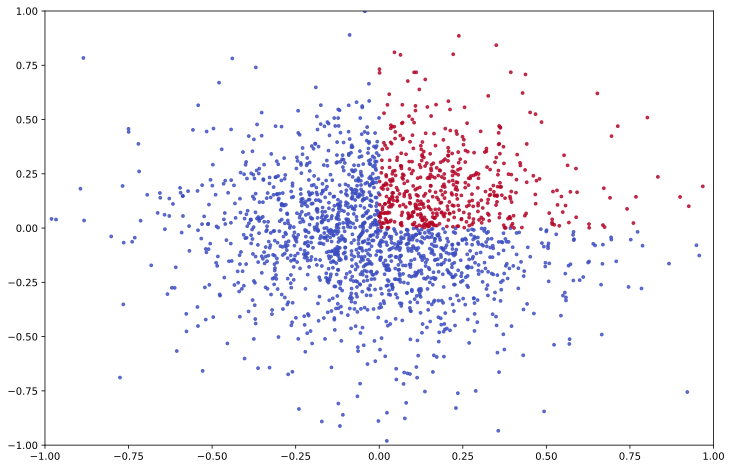

In [4]:
# Increasing the size of the plots
figsize = np.array(plt.rcParams["figure.figsize"]) * 2
# by symmetry x and y axis should be in same range
x_max = np.amax(x, axis=0) * 1.2
x_min = np.amin(x, axis=0) * 1.2

plt.figure(figsize=figsize.tolist())
plt.scatter(
    x[:, 0], x[:, 1], marker='o', c=y, alpha=0.8, cmap='coolwarm',
    s=8, edgecolor='face')
plt.grid(False)
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.show()


In [5]:
# 80:20 split on training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


In [6]:
# Prediction model
# This model does NOT aware of adversarial examples.
# SVM
gamma = 10.0
C = 1000

model_svm = svm.SVC(
    kernel='rbf', random_state=random_state, gamma=gamma, C=C)
model_svm.fit(x_train, y_train)

pred_train = model_svm.predict(x_train)
score_train = accuracy_score(y_train, pred_train)

pred_test = model_svm.predict(x_test)
score_test = accuracy_score(y_test, pred_test)

print(f'With gamma = {gamma} and C = {C}')
print(f'Accuracy on train set = {score_train*100:.4f}%')
print(f'Accuracy on test set  = {score_test*100:.4f}%')


With gamma = 10.0 and C = 1000
Accuracy on train set = 99.6250%
Accuracy on test set  = 99.2500%


In [7]:
# Sanity check
x_basis, y_basis = and_gen.get_basic_set(shift=[[-0.5, -0.5]])
utils.run_basic_test(x_basis, y_basis, model_svm)


Passed basic test


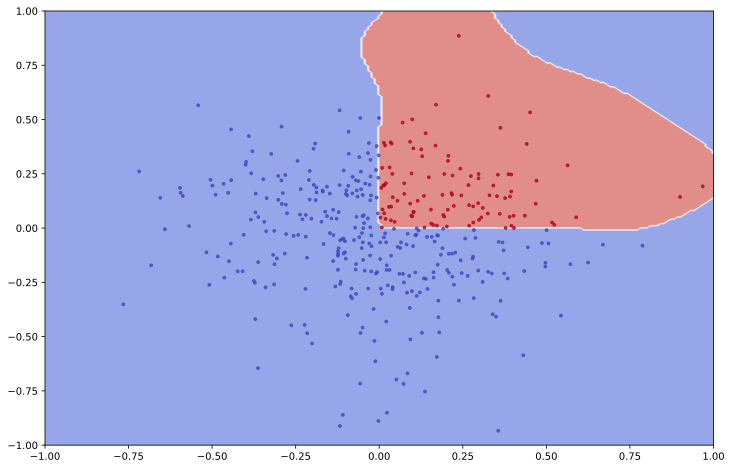

In [8]:
h = .01

xx, yy = np.meshgrid(
    np.arange(x_min[0], x_max[0], h), 
    np.arange(x_min[1], x_max[1], h))
Z = model_svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=figsize.tolist())
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.6)
plt.scatter(
    x_test[:, 0], x_test[:, 1], c=y_test, marker='o', alpha=0.8,
    cmap='coolwarm', s=8, edgecolor='face')
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.show()


In [9]:
model_svm.get_params()


{'C': 1000,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 10.0,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 4096,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [10]:
# Creating adversarial examples
# Grey-box scenario, the attacker has the access on the training set
ind_train_c1 = np.where(y_train == 1)
x_train_c1 = x_train[ind_train_c1]
y_train_c1 = np.ones(len(x_train_c1))
mu_train_c1 = np.mean(x_train_c1, axis=0)

ind_train_c0 = np.where(y_train == 0)
x_train_c0 = x_train[ind_train_c0]
y_train_c0 = np.zeros(len(x_train_c0))
mu_train_c0 = np.mean(x_train_c0, axis=0)

print(f'Positive mean = [{mu_train_c1[0]:.4f}, {mu_train_c1[1]:.4f}]')
print(f'Negative mean = [{mu_train_c0[0]:.4f}, {mu_train_c0[1]:.4f}]')


Positive mean = [0.2069, 0.2143]
Negative mean = [-0.0589, -0.0708]


In [11]:
# Generating Adversarial Examples from test set
# This implementation uses multiple iterations to update x, until all of them
# match the target classes.
epsilon = 0.0006

adversarial_examples = np.copy(x_test)  # make a clone
pred = pred_test
# Aimed to generate labels which completely opposite to the true labels, 
# not the prediction from SVM.
targets = and_gen.get_not_y(y_test)

epoch = 1
while np.array_equal(pred, targets) == False:
    adversarial_examples = adversarial.moving_mean(
        x=adversarial_examples,
        y=pred,
        targets=targets,
        means={0: mu_train_c0, 1: mu_train_c1},
        epsilon=epsilon,
        verbose=0,
        epoch=epoch)
    pred = model_svm.predict(adversarial_examples)
    epoch += 1

print(f'Completed after {epoch} epoch.')


Completed after 2131 epoch.


In [12]:
# Results
original_pred = model_svm.predict(x_test)
pred_ae = model_svm.predict(adversarial_examples)
y_ae = and_gen.get_y(adversarial_examples)

matches = np.equal(y_ae, pred_ae)
ind_misclassified = np.where(matches == False)[0]

# Print all misclassified samples
# for i in ind_misclassified:
#     print(
#         f'from [{x_test[i][0]: .4f}, {x_test[i][1]: .4f}] = {original_pred[i]}'
#         + f' to [{adversarial_examples[i][0]: .4f}, '
#         + f'{adversarial_examples[i][1]: .4f}] = {pred_ae[i]};'
#         + f' True y = {y_ae[i]}')

missclassified = len(ind_misclassified)
print(f'Misclassified = {missclassified}')

pred_miss = pred_ae[ind_misclassified]
false_neg = len(pred_miss[pred_miss==0])
false_pos = len(pred_miss[pred_miss==1])
print(f'Misclassified negative = {false_neg} ({false_neg/len(y_ae)*100:.4f}%)')
print(f'Misclassified positive = {false_pos} ({false_pos/len(y_ae)*100:.4f}%)')

count = len(matches[matches==False])
print(f'\nFound {len(ind_misclassified)} Adversarial Examples out of ' 
    + f'{len(y_ae)}. {len(ind_misclassified) / len(y_ae) * 100.0:.4f}% '
    + 'successful rate')


Misclassified = 195
Misclassified negative = 37 (9.2500%)
Misclassified positive = 158 (39.5000%)

Found 195 Adversarial Examples out of 400. 48.7500% successful rate


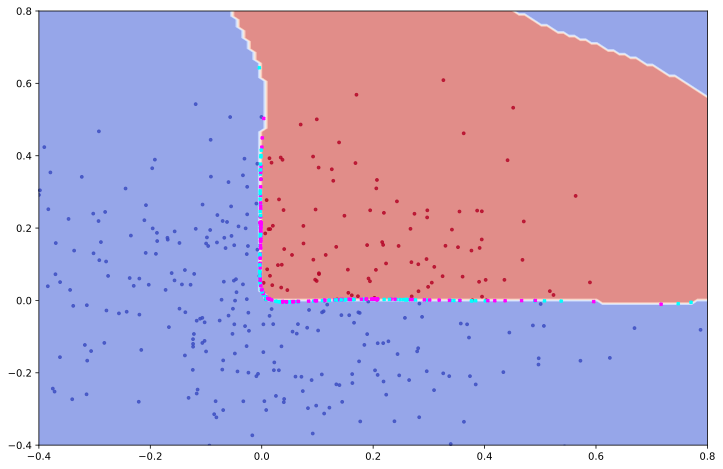

In [13]:
xx, yy = np.meshgrid(
    np.arange(x_min[0], x_max[0], h), 
    np.arange(x_min[1], x_max[1], h))
Z = model_svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=figsize.tolist())
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.6)
plt.scatter(
    x_test[:, 0], x_test[:, 1], c=y_test, marker='o', alpha=0.8,
    cmap='coolwarm', s=8, edgecolor='face')
plt.scatter(
    adversarial_examples[:, 0], adversarial_examples[:, 1], 
    c=pred_ae, marker='X', alpha=1, cmap='cool', s=8, edgecolor='face')
# We don't need to show the full range
plt.xlim(-0.4, 0.8)
plt.ylim(-0.4, 0.8)
plt.show()


In [14]:
# Apply Applicability Domain
# Use the adversarial examples from previous step
x_ae = adversarial_examples
y_ae = and_gen.get_y(x_ae)
pred_ae = pred_ae = model_svm.predict(x_ae)
score = accuracy_score(y_ae, pred_ae)

print(f'Accuracy on the given set = {score*100:.4f}%')

# Applicability Domain
# Stage 1 - Applicability
print('\n---------- Applicability ---------------')
x_passed_s1, ind_passed_s1 = ad.check_applicability(x_ae, x_train, y_train)
pred_passed_s1 = pred_ae[ind_passed_s1]

# Print
pass_rate = utils.get_rate(x_passed_s1, x_ae)
print(f'Pass rate = {pass_rate * 100:.4f}%')
# print('Blocked by Applicability Domain:')
# utils.print_blocked_samples(x_ae, ind_passed_s1)


Accuracy on the given set = 51.2500%

---------- Applicability ---------------
Pass rate = 100.0000%


In [15]:
# Stage 2 - Reliability
print('\n---------- Reliability -----------------')
# Parameters:
k = 9
# The test mean and training mean are close, thus using smaller zeta
zeta = 0.3

# Creating kNN models for each class
ind_train_c0 = np.where(y_train == 0)
model_knn_c0 = utils.unimodal_knn(x_train[ind_train_c0], k)

ind_train_c1 = np.where(y_train == 1)
model_knn_c1 = utils.unimodal_knn(x_train[ind_train_c1], k)

# Computing mean, standard deviation and threshold
mu_c0, sd_c0 = utils.get_distance_info(
    model_knn_c0, x_train[ind_train_c0], k, seen_in_train_set=True)
threshold_c0 = ad.get_reliability_threshold(mu_c0, sd_c0, zeta)

mu_c1, sd_c1 = utils.get_distance_info(
    model_knn_c1, x_train[ind_train_c1], k, seen_in_train_set=True)
threshold_c1 = ad.get_reliability_threshold(mu_c1, sd_c1, zeta)

x_passed_s2, ind_passed_s2 = ad.check_reliability(
    x_passed_s1,
    predictions=pred_passed_s1,
    models=[model_knn_c0, model_knn_c1],
    dist_thresholds=[threshold_c0, threshold_c1],
    classes=[0, 1],
    verbose=1
)
pred_passed_s2 = pred_passed_s1[ind_passed_s2]

# Print
print('Distance of c0 in training set:')
print('{:18s} = {:.4f}'.format('Mean', mu_c0))
print('{:18s} = {:.4f}'.format('Standard deviation', sd_c0))
print('{:18s} = {:.4f}\n'.format('Threshold', threshold_c0))

print('Distance of c1 in training set:')
print('{:18s} = {:.4f}'.format('Mean', mu_c1))
print('{:18s} = {:.4f}'.format('Standard deviation', sd_c1))
print('{:18s} = {:.4f}\n'.format('Threshold', threshold_c1))

pass_rate = utils.get_rate(x_passed_s2, x_passed_s1)
print(f'Pass rate = {pass_rate * 100:.4f}%')
# print('Blocked by Reliability Domain:')
# utils.print_blocked_samples(x_passed_s1, ind_passed_s2)



---------- Reliability -----------------

In 0 class:
Threshold = 0.0578
Average mean = 0.0313
Passed indices:
1, 2, 3, 6, 8, 12, 19, 23, 24, 25, 30, 33, 37, 41, 42, 46, 51, 68, 70, 71, 75, 76, 82, 87, 92, 95, 99, 103, 109, 114, 121, 123, 126, 129, 132, 137, 141, 142, 149, 150, 153, 154, 156, 157, 160, 163, 166, 167, 168, 176, 177, 180, 182, 184, 186, 190, 202, 205, 217, 218, 220, 225, 230, 231, 234, 236, 241, 257, 269, 275, 277, 278, 281, 291, 297, 299, 301, 303, 306, 309, 327, 329, 332, 338, 345, 349, 351, 352, 355, 357, 365, 375, 379, 384, 385, 393, 394

In 1 class:
Threshold = 0.0556
Average mean = 0.0332
Passed indices:
0, 4, 5, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 26, 27, 28, 29, 31, 32, 34, 35, 36, 38, 39, 40, 43, 44, 45, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 69, 72, 73, 74, 77, 78, 79, 81, 83, 84, 85, 86, 88, 89, 90, 91, 94, 96, 97, 100, 101, 102, 104, 105, 106, 107, 108, 110, 112, 113, 115, 116, 117, 118, 119, 120, 122, 124, 

In [16]:
# Stage 3 - Decidability
print('\n---------- Decidability ----------------')
model_knn = knn.KNeighborsClassifier(
    n_neighbors=k, n_jobs=-1, weights='distance')
model_knn.fit(x_train, y_train)

x_passed_s3, ind_passed_s3 = ad.check_decidability(
    x_passed_s2, pred_passed_s2, model_knn)


# Print
pass_rate = utils.get_rate(x_passed_s3, x_passed_s2)
print(f'Pass rate = {pass_rate * 100:.4f}%')
# print('Blocked by Decidability Domain:')
# utils.print_blocked_samples(x_passed_s2, ind_passed_s3)



---------- Decidability ----------------
Pass rate = 50.0000%


In [17]:
# Results
score = accuracy_score(y_ae, pred_ae)
print(f'Accuracy before AD = {score*100:.4f}%')
print()

pass_rate = utils.get_rate(x_passed_s3, x_ae)
y_passed = and_gen.get_y(x_passed_s3)
pred_after_ad = model_svm.predict(x_passed_s3)
score = accuracy_score(y_passed, pred_after_ad)
matches = np.equal(y_passed, pred_after_ad)
ind_misclassified = np.where(matches == False)[0]

print(f'\nOverall pass rate = {pass_rate * 100:.4f}%')
print(f'Accuracy after AD = {score*100:.4f}%')
print(f'{len(x_passed_s3)} out of {len(x_ae)}\n')

missclassified = len(ind_misclassified)
print(f'Misclassified = {missclassified}')

pred_miss = pred_after_ad[ind_misclassified]
false_neg = len(pred_miss[pred_miss==0])
false_pos = len(pred_miss[pred_miss==1])
print(f'Misclassified negative = {false_neg} ({false_neg/len(y_passed)*100:.4f}%)')
print(f'Misclassified positive = {false_pos} ({false_pos/len(y_passed)*100:.4f}%)')


Accuracy before AD = 51.2500%


Overall pass rate = 48.0000%
Accuracy after AD = 91.6667%
192 out of 400

Misclassified = 16
Misclassified negative = 4 (2.0833%)
Misclassified positive = 12 (6.2500%)


In [18]:
for i in ind_misclassified:
    print(
        f'[{adversarial_examples[i][0]: .4f}, ' 
        + f'{adversarial_examples[i][1]: .4f}] Pred.: {pred_after_ad[i]},'
        + f' Truth: {y_passed[i]}')


[-0.0027,  0.0517] Pred.: 1, Truth: 0
[-0.0018,  0.2148] Pred.: 1, Truth: 0
[ 0.2068,  0.0037] Pred.: 0, Truth: 1
[ 0.2414,  0.0028] Pred.: 1, Truth: 0
[-0.0015,  0.2149] Pred.: 0, Truth: 1
[ 0.1436,  0.0020] Pred.: 1, Truth: 0
[ 0.2069,  0.0037] Pred.: 0, Truth: 1
[ 0.2069,  0.0038] Pred.: 1, Truth: 0
[ 0.1557,  0.0030] Pred.: 0, Truth: 1
[-0.0027,  0.1018] Pred.: 1, Truth: 0
[ 0.0530, -0.0037] Pred.: 1, Truth: 0
[ 0.0658, -0.0038] Pred.: 1, Truth: 0
[-0.0019,  0.2148] Pred.: 1, Truth: 0
[-0.0020,  0.2347] Pred.: 1, Truth: 0
[ 0.3774, -0.0013] Pred.: 1, Truth: 0
[-0.0015,  0.2146] Pred.: 1, Truth: 0


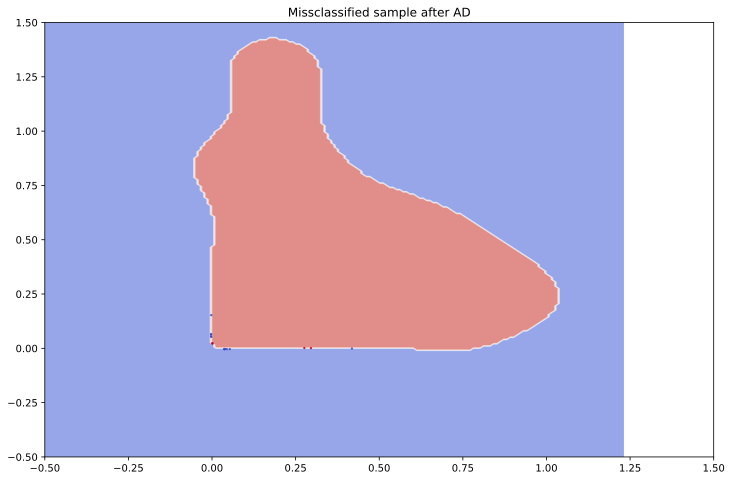

In [19]:
xx, yy = np.meshgrid(
    np.arange(x_min[0], x_max[0], h), 
    np.arange(x_min[1], x_max[1], h))
Z = model_svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=figsize.tolist())
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.6)

x_miss = x_passed_s3[ind_misclassified]
y_miss = y_passed[ind_misclassified]
plt.scatter(
    x_miss[:, 0], x_miss[:, 1], 
    c=y_miss, marker='.', alpha=0.8, cmap='coolwarm', s=8, edgecolor='face')
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.title('Missclassified sample after AD')
plt.show()
